In [18]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation

import numpy as np
from scipy.signal import find_peaks, butter, filtfilt
from scipy.ndimage import percentile_filter
import scipy.fftpack

import h5py
import re
import datetime

from sklearn.cluster import KMeans


In [2]:
symphony_file = h5py.File("C:\\Users\\zfj\\data\\frame_tracker_testing_new_splitter.h5","r")
# symphony_file = h5py.File("C:\\Users\\zfj\\data\\frame_tracker_testing - Copy.h5","r")
epoch_groups = []

dotNetOffset = 1e6*60*60 #ticks per hour
def append_epochs(name, g):
    if 'protocolID' in g.attrs and g.attrs['protocolID'] == b'sa_labs.protocols.stage.SpotGridAndChirp': 
        # print({k:v for k,v in g['protocolParameters'].attrs.items()})
        epochs = {
            'start_times':[],
            'frame_timing':[],
            'trial_type':[],
            'cx':[],
            'cy':[],
            'amp1':[],
        }   
        for epoch in g['epochs']:
            resps = g['epochs'][epoch]['responses']
            for resp in resps:
                if 'Frame timing' in resp:
                    epochs['frame_timing'].append(resps[resp]['data']['quantity'])
                if 'Amp1' in resp:
                    epochs['amp1'].append(resps[resp]['data']['quantity'])
            epochs['start_times'].append(g['epochs'][epoch].attrs['startTimeDotNetDateTimeOffsetTicks'])
            epochs['trial_type'].append(g['epochs'][epoch]['protocolParameters'].attrs['trialType'])
            if epochs['trial_type'][-1] == b'grid':
                epochs['cx'].append(g['epochs'][epoch]['protocolParameters'].attrs['cx'])
                epochs['cy'].append(g['epochs'][epoch]['protocolParameters'].attrs['cy'])
            else:
                epochs['cx'].append(np.array([]))
                epochs['cy'].append(np.array([]))
            
        epoch_groups.append({**g['protocolParameters'].attrs, 'epochs':epochs})
symphony_file.visititems(append_epochs)

# plt.scatter(epochs['cx'],epochs['cy'])


In [24]:
# print(epoch_groups[0]['epochs'])

print([len(e['epochs']['start_times']) for e in epoch_groups])
# print(epoch_groups[1]['epochs'])
# epochs = epoch_groups[1]['epochs']
# params = {k:v for k,v in epoch_groups[1].items() if k != 'epochs'}
# epochs['trial_type']
# print(epochs['cx'])

epochs = {
    'start_times': [x for eg in epoch_groups for x in eg['epochs']['start_times']],
    'trial_type': [x for eg in epoch_groups for x in eg['epochs']['trial_type']],
    'frame_timing': [x for eg in epoch_groups for x in eg['epochs']['frame_timing']],
    'amp1': [x for eg in epoch_groups for x in eg['epochs']['amp1']],
    
    'cx': [x for eg in epoch_groups for x in eg['epochs']['cx']],
    'cy': [x for eg in epoch_groups for x in eg['epochs']['cy']],
}
#should filter / iterate on matching epoch blocks ....

sf = 10000

[28, 28]


In [25]:
## Learn the trigger levels and noise using k-means clustering on the trigger channel

trig = np.asarray(epochs['frame_timing']).reshape(-1,1)

# trig[:,1::2,:] = np.flip(trig[:,1::2,:], axis=2) #bidi scanning
# trig = trig.reshape(-1,1)

# If we don't include the start trigger, we will probably not learn it.
# Find the top 25 spikes in the trigger channel. These are likely start triggers
trig_candidates = np.argpartition(trig[2:] - trig[:-2],-25, axis=0)[-25:].flatten()

# Train the classifier using windows around the putative start triggers
km = KMeans(n_clusters=5, algorithm='elkan').fit(trig[trig_candidates[:,None] + np.arange(0,50000)].reshape(-1,1)) #~7s
fl = km.predict(trig)

# Reorder the predictions in ascending voltage order
idx = np.argsort(km.cluster_centers_.flatten())
lut = np.zeros_like(idx)
lut[idx] = np.arange(len(idx))
fl = lut[fl]

print(km.cluster_centers_)


[[6.20619024]
 [0.91569662]
 [4.2101358 ]
 [2.59048515]
 [0.06854144]]


In [29]:
## Calculate the frame number from the trigger labels

flips = np.where(np.diff(fl))[0]
flips = np.insert(flips,(0,-1),(0,len(fl)-1))


fi = np.empty_like(fl, dtype=float)
fi[:flips[1]] = np.nan

rm = []
last_flip = 0
for i in range(1,len(flips)):
    if (flips[i] - flips[i-1] < sf/140):
        rm.append(i)
        continue
    elif fl[flips[i]] == 4:
        fi[last_flip:flips[i]] = 3 # the first 4 frames have an identical signature, should be preTime
    elif fl[flips[i]] == 0:
        fi[last_flip:flips[i]] = ((fi[last_flip-1] + 4)//4)*4
    elif fl[flips[i]] == 3:
        fi[last_flip:flips[i]] = ((fi[last_flip-1] + 3)//4)*4 + 1
    elif fl[flips[i]] == 1:
        fi[last_flip:flips[i]] = ((fi[last_flip-1] + 2)//4)*4 + 2
    elif fl[flips[i]] == 2:
        fi[last_flip:flips[i]] = ((fi[last_flip-1] + 1)//4)*4 + 3
    
    last_flip = flips[i]
fi[-1] = fi[-2]
flips = np.delete(flips, rm)

print(len(flips), len(flips)/60/35)

117349 55.88047619047619


(-1.0, 25.0)

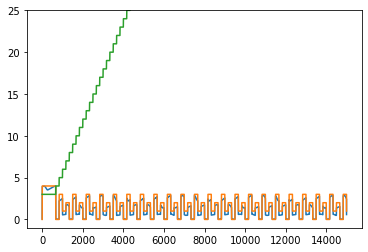

In [36]:
plt.plot(trig[trig_candidates[1,None] + np.arange(0,15000)] / trig.max() * (km.n_clusters-1))
plt.plot(fl[trig_candidates[1,None] + np.arange(0,15000)])
plt.plot(fi[trig_candidates[1,None] + np.arange(0,15000)])
plt.ylim(-1, 25)

Dropped 28 frames in 54 trials (0.024%)


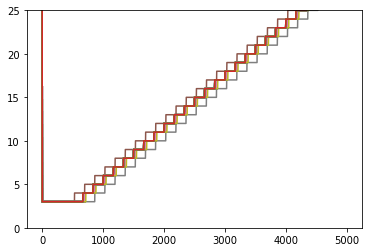

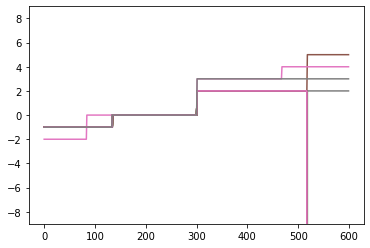

In [46]:
## Find dropped frames and trial start times

dropped = np.where(np.diff(fi)>1)[0]
trial = np.where(np.diff(fi)<0)[0]
print(f'Dropped {len(dropped)} frames in {len(trial)} trials ({len(dropped)/len(flips) * 100:.03f}%)')

plt.plot(fi[trial[:,None] + np.arange(0,5000)].squeeze().T)
plt.ylim(0,25)

plt.figure()
plt.plot((fi[dropped[:,None] + np.arange(-300,300)] - fi[dropped[:,None]]).squeeze().T)
plt.ylim(-9,9)
plt.show()
